In [1]:
import torch
import torchvision
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np

# Import and split dataset

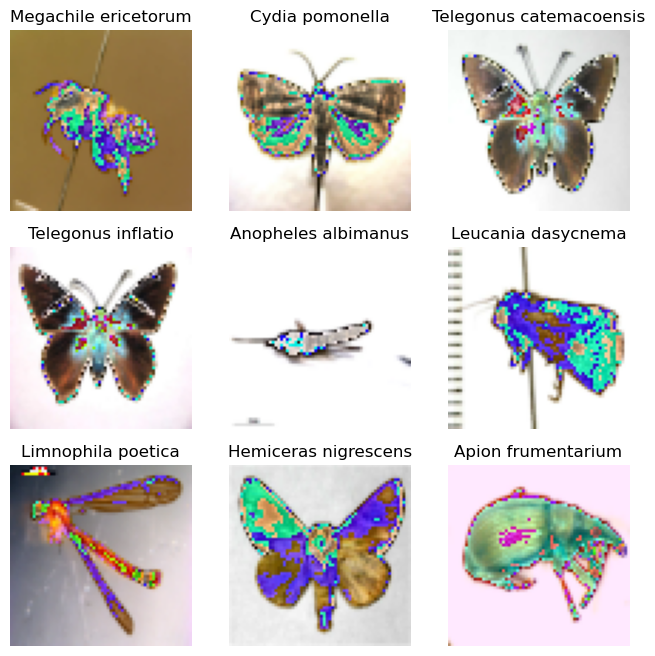

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)
imsize = 64
tform = transforms.Compose([transforms.Resize((imsize,imsize)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_dataset), size=(1,)).item()
    img, label = image_dataset[sample_idx]
    img = transforms.functional.to_pil_image(img)
    figure.add_subplot(rows, cols, i)
    species_name = (list(image_dataset.class_to_idx.keys())[label]).replace('_',' ')
    plt.title(species_name)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [3]:
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_val, X_test, y_train_val, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
print(y_test)
train_data = X_train_val
train_data['species_name'] = y_train_val

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)
from torch.utils.data import Dataset, DataLoader
 
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 9991, dtype: object
32424


32424

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_size = 100 
batch_size =  16

In [5]:
train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=True, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

print(len(train_imgs.indices))
print(len(val_imgs.indices))
print(len(test_imgs.indices))


13039
6955
12430


In [6]:
print(y_test.shape)
print(y_train.shape)

(9991,)
(10840,)


In [7]:
# USED TO GENERATE ONLY FAKE IMAGES FROM DESCRIBED SPECIES
described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)

In [8]:
described_species_labels.shape

(703,)

In [9]:
list(image_dataset.class_to_idx.keys())[45]

'Agrotis_ipsilon'

In [10]:
described_species_labels

array([   0,    1,    2,    3,    4,    5,    6,    7,    9,   12,   13,
         15,   16,   18,   19,   21,   22,   23,   26,   29,   30,   32,
         33,   37,   39,   40,   42,   43,   45,   46,   47,   49,   50,
         51,   52,   53,   54,   56,   57,   60,   63,   64,   69,   70,
         73,   74,   75,   76,   77,   78,   79,   80,   82,   83,   84,
         85,   86,   88,   91,   95,   96,   97,   98,  100,  101,  102,
        103,  106,  108,  110,  111,  113,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  126,  127,  131,  132,  134,  135,  136,
        138,  139,  140,  141,  142,  143,  145,  147,  148,  149,  151,
        153,  154,  156,  158,  159,  160,  163,  164,  165,  167,  168,
        170,  171,  172,  173,  174,  177,  178,  180,  181,  182,  184,
        185,  191,  194,  195,  196,  199,  202,  203,  204,  205,  206,
        207,  208,  209,  210,  211,  212,  213,  214,  215,  216,  217,
        219,  220,  221,  222,  223,  224,  225,  2

# Initialize and train the models

In [11]:
import os 
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(100, latent_size, 1, 1,device=device)
sample_random_classes = torch.tensor(np.random.randint(0, n_classes, fixed_latent.shape[0]),device=device)

In [12]:
import types
import ops
def define_modules(gan_config):
    layers = types.SimpleNamespace()
    if gan_config.apply_g_sn:
        layers.g_conv2d = ops.snconv2d
        layers.g_deconv2d = ops.sndeconv2d
        layers.g_linear = ops.snlinear
        layers.g_embedding = ops.sn_embedding
    else:
        layers.g_conv2d = ops.conv2d
        layers.g_deconv2d = ops.deconv2d
        layers.g_linear = ops.linear
        layers.g_embedding = ops.embedding

    if gan_config.apply_d_sn:
        layers.d_conv2d = ops.snconv2d
        layers.d_deconv2d = ops.sndeconv2d
        layers.d_linear = ops.snlinear
        layers.d_embedding = ops.sn_embedding
    else:
        layers.d_conv2d = ops.conv2d
        layers.d_deconv2d = ops.deconv2d
        layers.d_linear = ops.linear
        layers.d_embedding = ops.embedding

    if gan_config.g_cond_mtd == "cBN":
        layers.g_bn = ops.ConditionalBatchNorm2d
    elif gan_config.g_cond_mtd == "W/O":
        layers.g_bn = ops.batchnorm_2d
    else:
        raise NotImplementedError

    if not gan_config.apply_d_sn:
        layers.d_bn = ops.batchnorm_2d

    if gan_config.g_act_fn == "ReLU":
        layers.g_act_fn = nn.ReLU(inplace=True)
    elif gan_config.g_act_fn == "Leaky_ReLU":
        layers.g_act_fn = nn.LeakyReLU(negative_slope=0.1, inplace=True)
    elif gan_config.g_act_fn == "ELU":
        layers.g_act_fn = nn.ELU(alpha=1.0, inplace=True)
    elif gan_config.g_act_fn == "GELU":
        layers.g_act_fn = nn.GELU()
    elif gan_config.g_act_fn == "Auto":
        pass
    else:
        raise NotImplementedError

    if gan_config.d_act_fn == "ReLU":
        layers.d_act_fn = nn.ReLU(inplace=True)
    elif gan_config.d_act_fn == "Leaky_ReLU":
        layers.d_act_fn = nn.LeakyReLU(negative_slope=0.1, inplace=True)
    elif gan_config.d_act_fn == "ELU":
        layers.d_act_fn = nn.ELU(alpha=1.0, inplace=True)
    elif gan_config.d_act_fn == "GELU":
        layers.d_act_fn = nn.GELU()
    elif gan_config.g_act_fn == "Auto":
        pass
    else:
        raise NotImplementedError
    return layers
    
config = types.SimpleNamespace()
config.d_act_fn = "ReLU"
config.g_act_fn = "ReLU"
config.apply_d_sn= True
config.apply_g_sn= True
config.g_cond_mtd= "cBN"

l=define_modules(config)

In [13]:
import importlib
import modelReACGAN as m
importlib.reload(m)


discriminator = m.Discriminator(imsize,128,True,True,[1],"D2DCE",2048,True,num_classes=1050,d_init="ortho",d_depth=2,mixed_precision=True,MODULES=l)
discriminator.cuda()

generator = m.Generator(100,128,imsize,128,True,[4],"cBN",num_classes=1050,g_init="ortho",g_depth=2,mixed_precision=True,MODULES=l)
generator.cuda()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.0, 0.999))
#discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),lr=1e-5)
#generator_optimizer = torch.optim.RMSprop(generator.parameters(),lr=1e-5)
generator_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-5,betas=(0.0, 0.999))


n_params = dataset_utils.count_trainable_parameters(discriminator);
print(n_params)
n_params = dataset_utils.count_trainable_parameters(generator);
print(n_params)


writer = SummaryWriter()

84520322
55822084


In [62]:
import torch.nn.functional as F
class Data2DataCrossEntropyLoss(torch.nn.Module):
    def __init__(self, num_classes, temperature, m_p, device):
        super(Data2DataCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.temperature = temperature
        self.m_p = m_p
        self.device = device
        self.calculate_similarity_matrix = self._calculate_similarity_matrix()
        self.cosine_similarity = torch.nn.CosineSimilarity(dim=-1)

    def _calculate_similarity_matrix(self):
        return self._cosine_simililarity_matrix

    def _cosine_simililarity_matrix(self, x, y):
        v = self.cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def make_index_matrix(self, labels):
        labels = labels.detach().cpu().numpy()
        num_samples = labels.shape[0]
        mask_multi, target = np.ones([self.num_classes, num_samples]), 0.0

        for c in range(self.num_classes):
            c_indices = np.where(labels==c)
            mask_multi[c, c_indices] = target
        return torch.tensor(mask_multi).type(torch.long).to(self.device)

    def remove_diag(self, M):
        h, w = M.shape
        assert h==w, "h and w should be same"
        mask = np.ones((h, w)) - np.eye(h)
        mask = torch.from_numpy(mask)
        mask = (mask).type(torch.bool).to(self.device)
        return M[mask].view(h, -1)

    def forward(self, embed, proxy, label, **_):
        # calculate similarities between sample embeddings
        sim_matrix = self.calculate_similarity_matrix(embed, embed) + self.m_p - 1
        # remove diagonal terms
        sim_matrix = self.remove_diag(sim_matrix/self.temperature)
        # for numerical stability
        sim_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        sim_matrix = F.relu(sim_matrix) - sim_max.detach()

        # calculate similarities between sample embeddings and the corresponding proxies
        smp2proxy = self.cosine_similarity(embed, proxy)
        # make false negative removal
        removal_fn = self.remove_diag(self.make_index_matrix(label)[label])
        # apply the negative removal to the similarity matrix
        improved_sim_matrix = removal_fn*torch.exp(sim_matrix)

        # compute positive attraction term
        pos_attr = F.relu((self.m_p - smp2proxy)/self.temperature)
        # compute negative repulsion term
        neg_repul = torch.log(torch.exp(-pos_attr) + improved_sim_matrix.sum(dim=1))
        # compute data to data cross-entropy criterion
        criterion = pos_attr + neg_repul
        return criterion.mean()
def d_hinge(d_logit_real, d_logit_fake):
    return torch.mean(F.relu(1. - d_logit_real)) + torch.mean(F.relu(1. + d_logit_fake))
def g_hinge(d_logit_fake):
    return -torch.mean(d_logit_fake)

In [63]:
cond_loss = Data2DataCrossEntropyLoss(n_classes,0.5,0.98,device)
cond_lambda = 1 

In [16]:
g_dict = torch.load('checkpoints/generatorReACGAN17')
generator.load_state_dict(g_dict['model_state_dict'])
d_dict = torch.load('checkpoints/discriminatorReACGAN17')
discriminator.load_state_dict(d_dict['model_state_dict'])
generator_optimizer.load_state_dict(g_dict['optimizer_state_dict'])
discriminator_optimizer.load_state_dict(d_dict['optimizer_state_dict'])

In [21]:
d_dict

{'epoch': 2,
 'model_state_dict': OrderedDict([('blocks.0.0.conv2d0.bias',
               tensor([-0.0361, -0.0033, -0.0069, -0.0174, -0.0004,  0.0065,  0.0019, -0.0024,
                       -0.0054, -0.0330, -0.0138, -0.0073, -0.0032, -0.0111, -0.0003, -0.0074,
                       -0.0092, -0.0147, -0.0167, -0.0099, -0.0122, -0.0116, -0.0461,  0.0006,
                       -0.0303,  0.0003, -0.0026, -0.0039, -0.0044, -0.0098, -0.0054, -0.0045,
                       -0.0086, -0.0080, -0.0281, -0.0048, -0.0203, -0.0029, -0.0071, -0.0104,
                       -0.0130, -0.0112, -0.0131,  0.0063, -0.0365, -0.0038, -0.0294, -0.0150,
                       -0.0256, -0.0124, -0.0282, -0.0233, -0.0113, -0.0108, -0.0105, -0.0170,
                       -0.0177, -0.0274, -0.0092, -0.0036, -0.0037, -0.0035, -0.0092, -0.0038,
                       -0.0069, -0.0452, -0.0059, -0.0061, -0.0195,  0.0210, -0.0077, -0.0135,
                       -0.0131, -0.0300, -0.0166, -0.0414, -0.0080, -0

In [25]:
from tqdm.notebook import tqdm
discriminator.train()
generator.train()
for epoch in range(17,50):
    for real_images, real_classes in tqdm(dataloaders['train']):
        real_images = real_images.to(device)
        real_classes = real_classes.to(device)
        #TRAIN DISCRIMINATOR
        for k in range(2):
            discriminator_optimizer.zero_grad()
            #use discriminator on real images
            real_dict = discriminator(real_images,real_classes)
            #use discriminator on fake images
            with torch.no_grad():
                random_classes = torch.tensor(described_species_labels[np.random.randint(0, len(described_species_labels), batch_size)],device=device)
                t = generator(torch.randn(batch_size,100).to(device),random_classes,eval = True)
            fake_dict = discriminator(t,random_classes)
            #Compute the two losses
            dis_acml_loss = d_hinge(real_dict["adv_output"], fake_dict["adv_output"])
            real_cond_loss = cond_loss(**real_dict)
            dis_acml_loss += cond_lambda * real_cond_loss
            dis_acml_loss.backward()
            discriminator_optimizer.step()


        
        #TRAIN GENERATOR
        generator_optimizer.zero_grad()
        random_classes = torch.tensor(described_species_labels[np.random.randint(0, len(described_species_labels), batch_size)],device=device)
        t = generator(torch.randn(batch_size,100).to(device),random_classes,eval = True)
        fake_dict = discriminator(t,random_classes)
        gen_acml_loss = g_hinge(fake_dict["adv_output"])
        fake_cond_loss = cond_loss(**fake_dict)
        gen_acml_loss += cond_lambda * fake_cond_loss
        gen_acml_loss.backward()
        generator_optimizer.step()
    
    print(f"disc loss={dis_acml_loss.item()}",end=',')
    print(f"gen loss={gen_acml_loss.item()}")
    with torch.no_grad():
        t = generator(torch.randn(100,100).to(device),torch.tensor(np.arange(100)).to(device),eval = True)
    t = dataset_utils.denorm(t)
    p = torchvision.transforms.functional.to_pil_image(torchvision.utils.make_grid(t))
    p.save(f"generated/ex{epoch}.jpg")
        #torch.cuda.empty_cache()
        #loss_d, real_score, fake_score, class_accuracy_real, class_accuracy_fake

  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.201171875,gen loss=4.76953125


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.416015625,gen loss=5.0


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=1.87109375,gen loss=5.73828125


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.3671875,gen loss=5.72265625


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.78515625,gen loss=6.06640625


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.224609375,gen loss=5.33984375


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.16796875,gen loss=5.7890625


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.615234375,gen loss=6.1640625


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.6640625,gen loss=5.92578125


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.72265625,gen loss=5.890625


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.822265625,gen loss=5.56640625


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.59765625,gen loss=5.80078125


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.45703125,gen loss=5.953125


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.376953125,gen loss=5.5546875


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.50390625,gen loss=5.703125


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.4609375,gen loss=6.046875


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.25,gen loss=5.36328125


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.474609375,gen loss=6.2578125


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.720703125,gen loss=6.3984375


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=2.744140625,gen loss=6.07421875


  0%|          | 0/815 [00:00<?, ?it/s]

disc loss=1.92578125,gen loss=5.59375


  0%|          | 0/815 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
for i in range(1):
    with torch.no_grad():
        random_classes = torch.tensor(described_species_labels[np.random.randint(0, len(described_species_labels), 100)],device=device)
        print(np.array(list(image_dataset.class_to_idx.keys()))[random_classes.cpu().numpy()])
        t = generator(torch.randn(100,100).to(device),random_classes,eval = True)
    t = dataset_utils.denorm(t)
    print(t.shape)
    p = torchvision.transforms.functional.to_pil_image(torchvision.utils.make_grid(t))
    p.save(f"generated/example{i}.jpg")
    #p.show()

['Arge_berberidis' 'Tachyta_nana' 'Hylobius_abietis' 'Spilosoma_curvata'
 'Condica_illecta' 'Eutomostethus_luteiventris' 'Nystalea_striata'
 'Rhagium_mordax' 'Apamea_sublustris' 'Apamea_scolopacina'
 'Bembidion_tibiale' 'Araptus_carinifrons' 'Cicindela_campestris'
 'Olibrus_millefolii' 'Urbanus_alva' 'Cerceris_rybyensis'
 'Cydia_pomonella' 'Crambus_praefectellus' 'Chloroclystis_insigillata'
 'Stenus_clavicornis' 'Poecilus_versicolor' 'Hylaeus_clypearis'
 'Ethmia_helenmillerae' 'Chaetocnema_hortensis' 'Argyrotaenia_mariana'
 'Elaphria_devara' 'Phaedon_cochleariae' 'Mordella_aculeata'
 'Acrolophus_kearfotti' 'Bembidion_normannum' 'Atheta_incognita'
 'Pselaphus_heisei' 'Oxybelus_argentatus' 'Orthocladius_nitidoscutellatus'
 'Hylaeus_confusus' 'Mordella_holomelaena' 'Smittia_longicosta'
 'Omalium_rugatum' 'Anthobium_atrocephalum' 'Aedes_aegypti'
 'Hypera_nigrirostris' 'Olibrus_bicolor' 'Astraptes_enotrus'
 'Aproaerema_taeniolella' 'Epuraea_unicolor' 'Agonum_emarginatum'
 'Helina_troene' 'O

In [34]:
real_dict['embed'].shape

torch.Size([16, 2048])

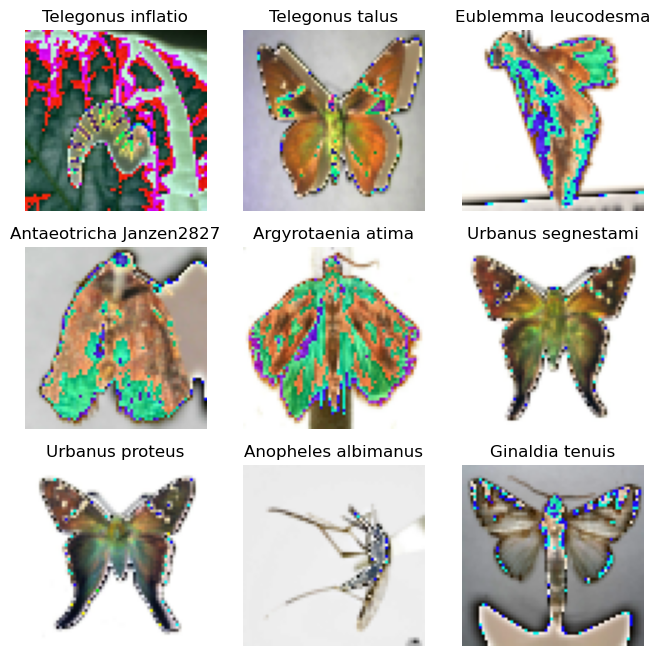

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 9991, dtype: object
32424
13039
6955
12430


In [14]:
df = pd.read_csv('final_dataset.csv',index_col=0)
imsize = 64
tform = transforms.Compose([transforms.Resize((imsize,imsize)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_dataset), size=(1,)).item()
    img, label = image_dataset[sample_idx]
    img = transforms.functional.to_pil_image(img)
    figure.add_subplot(rows, cols, i)
    species_name = (list(image_dataset.class_to_idx.keys())[label]).replace('_',' ')
    plt.title(species_name)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_val, X_test, y_train_val, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
print(y_test)
train_data = X_train_val
train_data['species_name'] = y_train_val

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)
from torch.utils.data import Dataset, DataLoader
 
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)
train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=False, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=batch_size,shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=False, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

print(len(train_imgs.indices))
print(len(val_imgs.indices))
print(len(test_imgs.indices))

In [20]:
torch.cuda.empty_cache()
discriminator.eval()
train_features = []
train_labels = np.array([]) 
with torch.no_grad():
    for batch, targets in dataloaders['train']:
        disc_dict = discriminator.extract_features(batch.to(device),targets.to(device)) 
        features_torch = disc_dict['feature']
        features_targets_torch = targets
        train_labels = np.concatenate((train_labels, features_targets_torch.cpu().numpy()))
        train_features.append(features_torch.cpu().numpy())
        torch.cuda.empty_cache()

train_features = np.concatenate(train_features)

torch.save(torch.tensor(train_features),'reacgan_image_train_features.pt')
torch.save(torch.tensor(train_labels),'reacgan_image_train_labels.pt')
torch.cuda.empty_cache()


discriminator.eval()
val_features = []
val_labels = np.array([])
with torch.no_grad():
    for batch,targets in dataloaders['val']:
        disc_dict = discriminator.extract_features(batch.to(device),targets.to(device)) 
        features_torch = disc_dict['feature']
        features_targets_torch = targets
        val_labels = np.concatenate((val_labels, features_targets_torch.cpu().numpy()))
        val_features.append(features_torch.cpu().numpy())
        torch.cuda.empty_cache()

val_features = np.concatenate(val_features)


torch.save(torch.tensor(val_features),'reacgan_image_val_features.pt')
torch.save(torch.tensor(val_labels),'reacgan_image_val_labels.pt')

In [21]:
train_features.shape
#plt.hist(train_features[1],bins=200)
#len(train_features[1].nonzero()[0])
val_features.shape

(6955, 32768)

In [20]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
#svm = LinearSVC(random_state=42)

# Make it an Multilabel classifier
#multilabel_classifier = MultiOutputClassifier(svm, n_jobs=-1)

# Fit the data to the Multilabel classifier
#svm = svm.fit(train_features, train_labels)

# Get predictions for test data
#y_test_pred = svm.predict(train_features)
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(train_features, train_labels)

KeyboardInterrupt: 

In [31]:
train_predicted_labels = clf.predict(train_features)
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==train_labels)/len(train_labels)}")

Training species accuracy:0.998389447043485


In [32]:
val_predicted_labels= clf.predict(val_features)
print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==val_labels)/len(val_labels)}")

Validation species accuracy:0.22818116462976276


In [33]:
temp_val_predicted_probs = clf.predict_proba(val_features)
val_predicted_probs = np.zeros((len(temp_val_predicted_probs),n_classes))
for i, cls in enumerate(np.arange(n_classes)):
    if cls in clf.classes_:
        val_predicted_probs[:, cls] = temp_val_predicted_probs[:, list(clf.classes_).index(cls)]

In [34]:

species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)
import math
n_correct_genus = 0
for i in range(len(val_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    
    #assert(int(val_predicted_labels[i])==int(val_predicted_probs[i].argmax()))
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[val_labels[i]]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(val_labels)}")


Validation genus accuracy: 0.5656362329259526


In [24]:
torch.cuda.empty_cache()

In [ ]:
raise Exception#old training
from dataset_utils import Fit_params, Save_samples_params
with torch.no_grad():
    pass
fit_p = Fit_params(discriminator_optimizer,generator_optimizer,discriminator,generator,dataloaders,device,writer,batch_size,n_classes,latent_size,described_species_labels)
save_p = Save_samples_params(fixed_latent,sample_random_classes,sample_dir)
losses_g, losses_d ,real_scores, fake_scores =m.fit(100,fit_p,save_p,start_idx=1)

In [ ]:

dataset_utils.species_label_to_genus_label()

# Altra roba

In [26]:
torch.save({
            'epoch':37,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': generator_optimizer.state_dict(),
            }, "checkpoints/generatorReACGAN37")
torch.save({
            'epoch': 37,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, "checkpoints/discriminatorReACGAN37")

In [ ]:
image_dataset.class_to_idx['Hemiceras_nigrescens']

In [ ]:
image_dataset.class_to_idx['Abax_parallelepipedus']

In [ ]:
raise Exception
fixed_latent2 = torch.randn(1, latent_size, 1, 1,device=device)

for class_fix in range(len(image_dataset.class_to_idx)):
    random_classes = torch.tensor(np.random.randint(class_fix, class_fix+1, fixed_latent2.shape[0]),device=device)
    print(random_classes)
    specie_name = list(image_dataset.class_to_idx.keys())[class_fix]
    specie_name_no_underscore= specie_name.replace("_"," ")
    if specie_name_no_underscore in list(X_train['species_name']):
        fake_images = generator(fixed_latent2,random_classes)
        fake_fname = f'{specie_name}.png'
        save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
        #writer.add_image('sample image',denorm(fake_images[0]),global_step=index)
        print('Saving', fake_fname)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    

In [ ]:
'Nola cucllatella' in list(X_train['species_name'])

In [ ]:
X_train['species_name']

In [ ]:

ct = nn.ConvTranspose2d( 100+embedding_size, 64 * 8, 4, 1, 0, bias=False)

In [ ]:
i = torch.ones(32,1100,1,1)

In [ ]:
x = ct(i)
print(x.shape)
up = nn.Upsample(scale_factor=2, mode='bilinear')
x = up(x)
print(x.shape)
conv1 = nn.Conv2d(64*8,64*8,1)
x = conv1(x)
print(x.shape)
x = up(x)
print(x.shape)
conv2 = nn.Conv2d(64*8,64*4,1)
x = conv2(x)
print(x.shape)
x = up(x)
print(x.shape)
conv3 = nn.Conv2d(64*4,64*2,1)
x = conv3(x)
print(x.shape)
x = up(x)
print(x.shape)
conv4 = nn.Conv2d(64*2,64*1,1)
x = conv4(x)
print(x.shape)
x = up(x)
print(x.shape)
conv5 = nn.Conv2d(64*1,3,1)
x = conv5(x)
print(x.shape)
x = up(x)
print(x.shape)

In [ ]:
a = torch.eye(2,3)
a[0][0]=2
a[0][1]=3
a

In [ ]:
a.mean(1)

In [ ]:
a.shape